# Multiple Linear Regression

The goal is to 
 - perform a Multiple Linear Regression Analysis to expand my professional portfolio
 - and use it as a stepping stone from the Simple Linear Regression to the General Linearized Models.

## Introduction:

In the CC_DS21_Honey_Production repository I performed the simplest type of regression model, simple linear regression, relating the dependent variable of "mean-total-production of honey across all states" to the independent variable of "year". In the following model, we will allow more than one independent variable. I did generate my own data for this exercise, as it allows for easy validation of the model and the validation is what in a lot of cases limits me to well explored datasets in the first place, the linearity of the model (in a sense, that I do not want to deal with transformation at this stage, but reserve this step for the final project of an analysis of real world data from kaggle) on top of data that lacks meaning or is highly correlated. In short, as the data is artificial and it's structure is known to me, formulating the model is largely skipped, although some aspects might be thematized.

### The data:
 - lin.csv, generated by custon_df_linear.py
 - has 8 variables
 - Y is dependent on X_1,X_2,C_1,C_2 and I_V
 - C_1 and C_2 are respectively highly correlated with (derived from) X_1 and X_2
 - I_V was sorted in ascending order, prior to generating Y, resulting in it having residuals with increasing variance, residuals being based on percentage of original value
 - D_1 and D_2 have no intentional relation to Y
 - all values have x = x * (1 + 0.01 * random.randint(-10,10)) applied to them after generation, to simulate residuals

The goal was to create a dataset, that can be used for "calibration", showing any obvious mistakes, or topics not fully understood. Especially in regarding to the tests for model assumptions. As preparation for regression on a real world dataset.

### The model:

The model is a first-order multiple regression model, meaning, there is no cross-product terms or terms in power of the independent variables.

y = $\beta_0$ + $\beta_1 x_1$ + . . . + $\beta_k x_k$ + $\epsilon$, 
    
with k + 1 parameters $\beta_0$, $\beta_1$, . . . , $\beta_k$, the response variable y and the k quantitative explanatory variables $x_1$, $x_2$, ... , $x_k$. $\beta_0$ is the y-intercept.

For sample size n the resulting linear model is:

$y = X\beta + \epsilon$

$$
\begin{pmatrix}
  y_{1} \\
  y_{2} \\
  \vdots  \\
  y_{n}
 \end{pmatrix} 
 =
 \begin{pmatrix}
  1 & x_{1,1} & x_{1,2} & \cdots & x_{1,k} \\
  1 & x_{2,1} & x_{2,2} & \cdots & x_{2,k} \\
  \vdots & \vdots  & \vdots  & \ddots & \vdots  \\
  1 & x_{n,1} & x_{n,2} & \cdots & x_{n,k} 
 \end{pmatrix}
 \times
 \begin{pmatrix}
  \beta_{0} \\
  \beta_{1} \\
  \vdots  \\
  \beta_{k}
 \end{pmatrix}
+
\begin{pmatrix}
  \epsilon_{1} \\
  \epsilon_{2} \\
  \vdots  \\
  \epsilon_{k}
 \end{pmatrix}
$$

The sum of the residuals is:

$Q = \epsilon^T\epsilon = \displaystyle\sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_1 - . . . - \beta_k x_i)^2$

For linear models the approximation for the Least Squares Estimator $\hat{\beta}$ is:

$\hat{\beta} = (X^T X)^{-1}X^Ty$

The most common measure of the quality of the model is the Coefficient of Determination ($R^2$):
The proportion of the variation in the dependent variable(y) that is predictable from the independent variables(x). (empirical variance = $s^2$, i-th observation out of n, $\bar{y}$ = mean y)

$\hat\epsilon_i = y_i - \hat{y}_i$

$R^2 = 1 - \frac{s^2(\hat{\epsilon})}{s^2(y)} = \frac{\displaystyle\sum_{i=1}^n \hat{\epsilon}_i^2}{\displaystyle\sum_{i=1}^n (y_i - \bar{y})^2}$

Adjusted $R^2$ which corrects for additional independent variables is defined as:

$\bar{R^2} = 1 - \frac{n - 1}{n - k - 1} (1 - R^2)$

#### The assumptions for multiple regression are:

 1. The mathematical form of the relation is correct, so E($\epsilon_i$) = 0 for all i.
 2. Var ($\epsilon_i$) = $\sigma_\epsilon^2$ for all i.
 3. The $\epsilon_i$ are independent.
 4. $\epsilon_i$ is normally disributed.
 


In [1]:
# import section ------------------------------------------------------------------------------------------------------------- #

# saving the model ----------------------------------------------------------------------------------------------------------- #
import pickle

# relational database and mathematics related libraries ---------------------------------------------------------------------- #
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats, special

# specific functions and models ---------------------------------------------------------------------------------------------- #
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Testing Model assumptions -------------------------------------------------------------------------------------------------- #
# Tests for heteroscedasticity ----------------------------------------------------------------------------------------------- #
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, het_goldfeldquandt
# Tests for normality -------------------------------------------------------------------------------------------------------- #
from statsmodels.stats.diagnostic import normal_ad, kstest_normal
from statsmodels.stats.stattools import jarque_bera, omni_normtest
# Tests for constant error variance ------------------------------------------------------------------------------------------ #
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
# Tests for autocorrelation -------------------------------------------------------------------------------------------------- #
from statsmodels.stats.stattools import durbin_watson


# libraries for visualization ------------------------------------------------------------------------------------------------ #
import seaborn as sns
import matplotlib.pyplot as plt

# load the data and save it into a dataframe --------------------------------------------------------------------------------- #
all_data_df = pd.read_csv("lin.csv")

# intial print to get an overview over the data and it's usability ----------------------------------------------------------- #
print(all_data_df.head())
#print(all_data_df.info())
#print(all_data_df.I_V.unique())

        X_1       X_2       D_1       D_2          C_1          C_2       I_V  \
0 -0.437668  0.643390  1.170696  0.407076 -2650.437668  2550.669650 -3.445651   
1  0.575635  1.020720  0.076582  0.812595 -2374.430361  2326.009862 -2.846992   
2  0.615925  0.708164 -0.805364 -0.167512 -2599.296086  2325.621314 -2.724445   
3 -0.705776 -0.075444 -0.580468  0.052559 -2325.663002  2624.922337 -2.941616   
4  0.057245  0.427900 -0.226747 -0.530859 -2624.942755  2725.452826 -2.497527   

          Y  
0 -0.576478  
1  0.077075  
2 -0.044579  
3 -0.847291  
4 -0.344569  


### Selecting the Variables

The initial task to address is to select a subset of k independent variables from the available data, these shoudl be based on causality and collinearity with the dependent variable. As correlation among the independent variables, simultaniously is something to avoid, a correlation matrix, scatterplot matrix and the VIF are some of the best tools to use. Also very usefull to check for over- or underspecification is the AIC, BIC (usually included in the summary printout), the PRESS-Statistic, $C_p$-Statistic. Or if a very methodic approach is warrented, backwards elimination and/or stepwise regression.

#### Correlation Heatmap

Correlation measures the strength of the linear relation between x and y. The stronger the correlation, the better x predicts y.
Given n pairs of observations ($x_i,y_i$), we compute the sample correlation r as:

$r_{xy} = \frac{\sum{(x_i-\bar{x})(y_i-\bar{y})}}{\sqrt{S_{xx} S_{yy}}} = \frac{S_{xy}}{\sqrt{S_{xx} S_{yy}}}$

 - $S_{xy} = \displaystyle\sum_{i}(x_i - \bar{x}) (y_i - \bar{y})$
 - $S_{xx} = \displaystyle\sum_{i}(x_i - \bar{x})^2$
 - $S_{yy} = \displaystyle\sum_{i}(y_i - \bar{y})^2 = SS(Total)$
 - SS = SumSquaredresiduals (prediction errors)
 - $S_{xy}$ = Sum(x-deviations * y-deviations)
 - $\bar{x}$ = mean x
 
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

https://seaborn.pydata.org/generated/seaborn.heatmap.html

<Figure size 640x480 with 0 Axes>

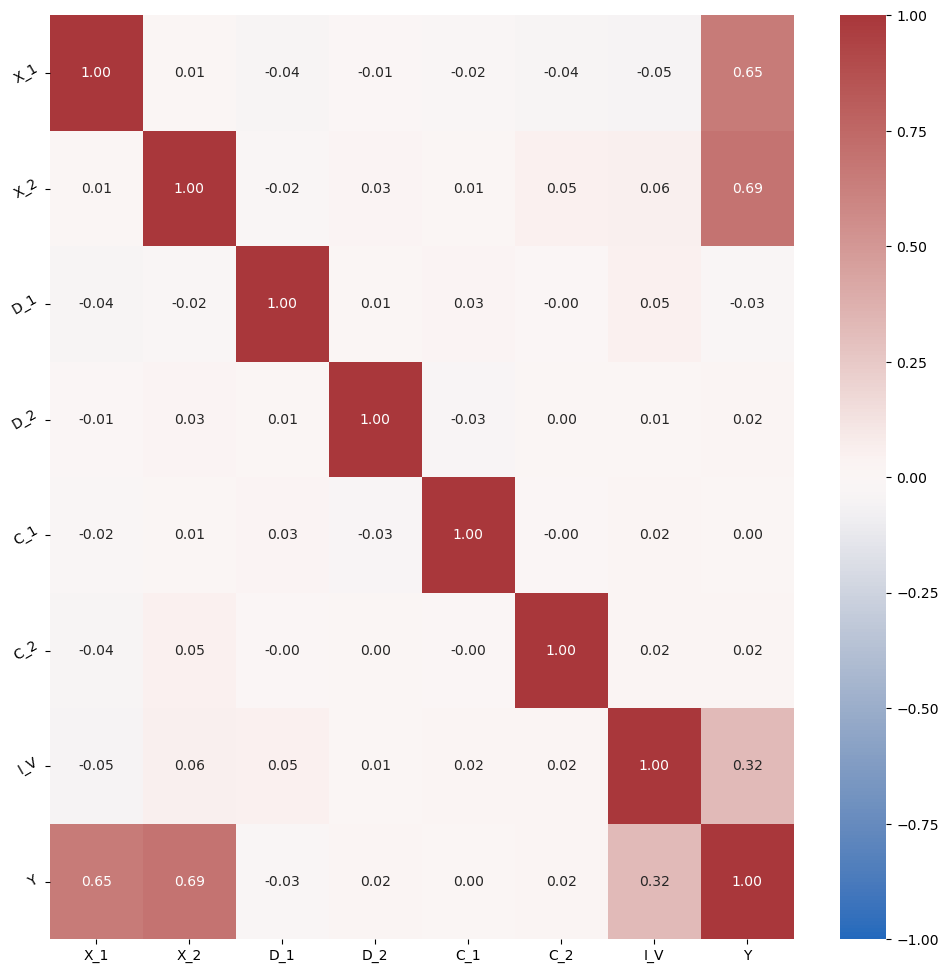

In [2]:
plt.clf()
# correlation matrix --------------------------------------------------------------------------------------------------------- #
corr = all_data_df.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corr, vmin=-1, vmax=1, xticklabels=corr.columns, yticklabels=corr.columns, cmap="vlag", annot=True, fmt=".2f")
plt.yticks(rotation=30)
plt.show()

<Figure size 640x480 with 0 Axes>

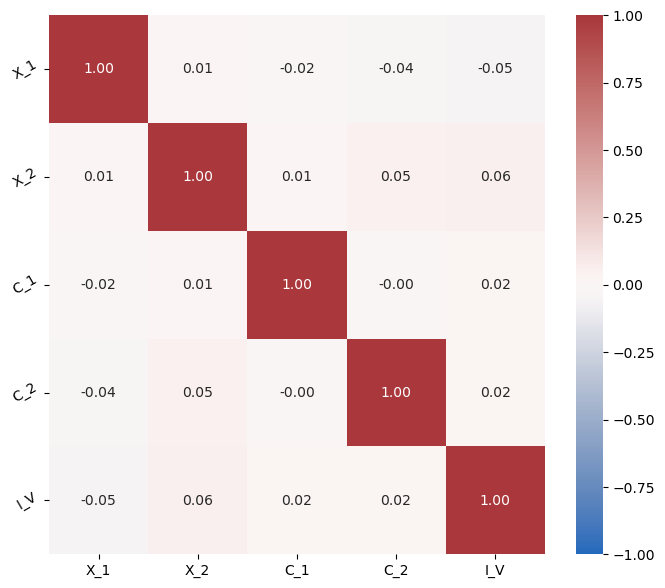

In [3]:
# significance level predefined for all statistical tests -------------------------------------------------------------------- #
alpha = 0.05

# removing explaining variables, which are highly correlated with other explaining variables --------------------------------- #
# or which do not add any or only very little explainatory value ------------------------------------------------------------- #
predicted_variable = ["Y"]

predicting_variables = ["X_1", "X_2", "C_1", "C_2", "I_V"]

columns_to_drop = list(all_data_df.columns.values)

for var in predicting_variables:
    columns_to_drop.remove(var)

all_data_Y_dropped = all_data_df.drop(columns=predicted_variable)

model_df = all_data_df.drop(columns=columns_to_drop)

# correlation matrix --------------------------------------------------------------------------------------------------------- #
model_corr = model_df.corr()

plt.clf()
plt.figure(figsize=(8,7))
sns.heatmap(model_corr, vmin=-1, vmax=1, xticklabels=model_corr.columns, yticklabels=model_corr.columns, cmap="vlag", annot=True, fmt=".2f")
plt.yticks(rotation=30)
plt.show()

#### Matrix of Scatter Plots

This pandas function allows to plot the values in each column against the values in the other columns. It helps with visioally identifying correlation.

 - correlation = -1 => dots arranged along a line, y ~ -x
 - correlation = -1 => dots arranged as a circular cloud, increasing density towards the center
 - correlation = 1 => dots arranged along a line, y ~ x

https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html

<Figure size 640x480 with 0 Axes>

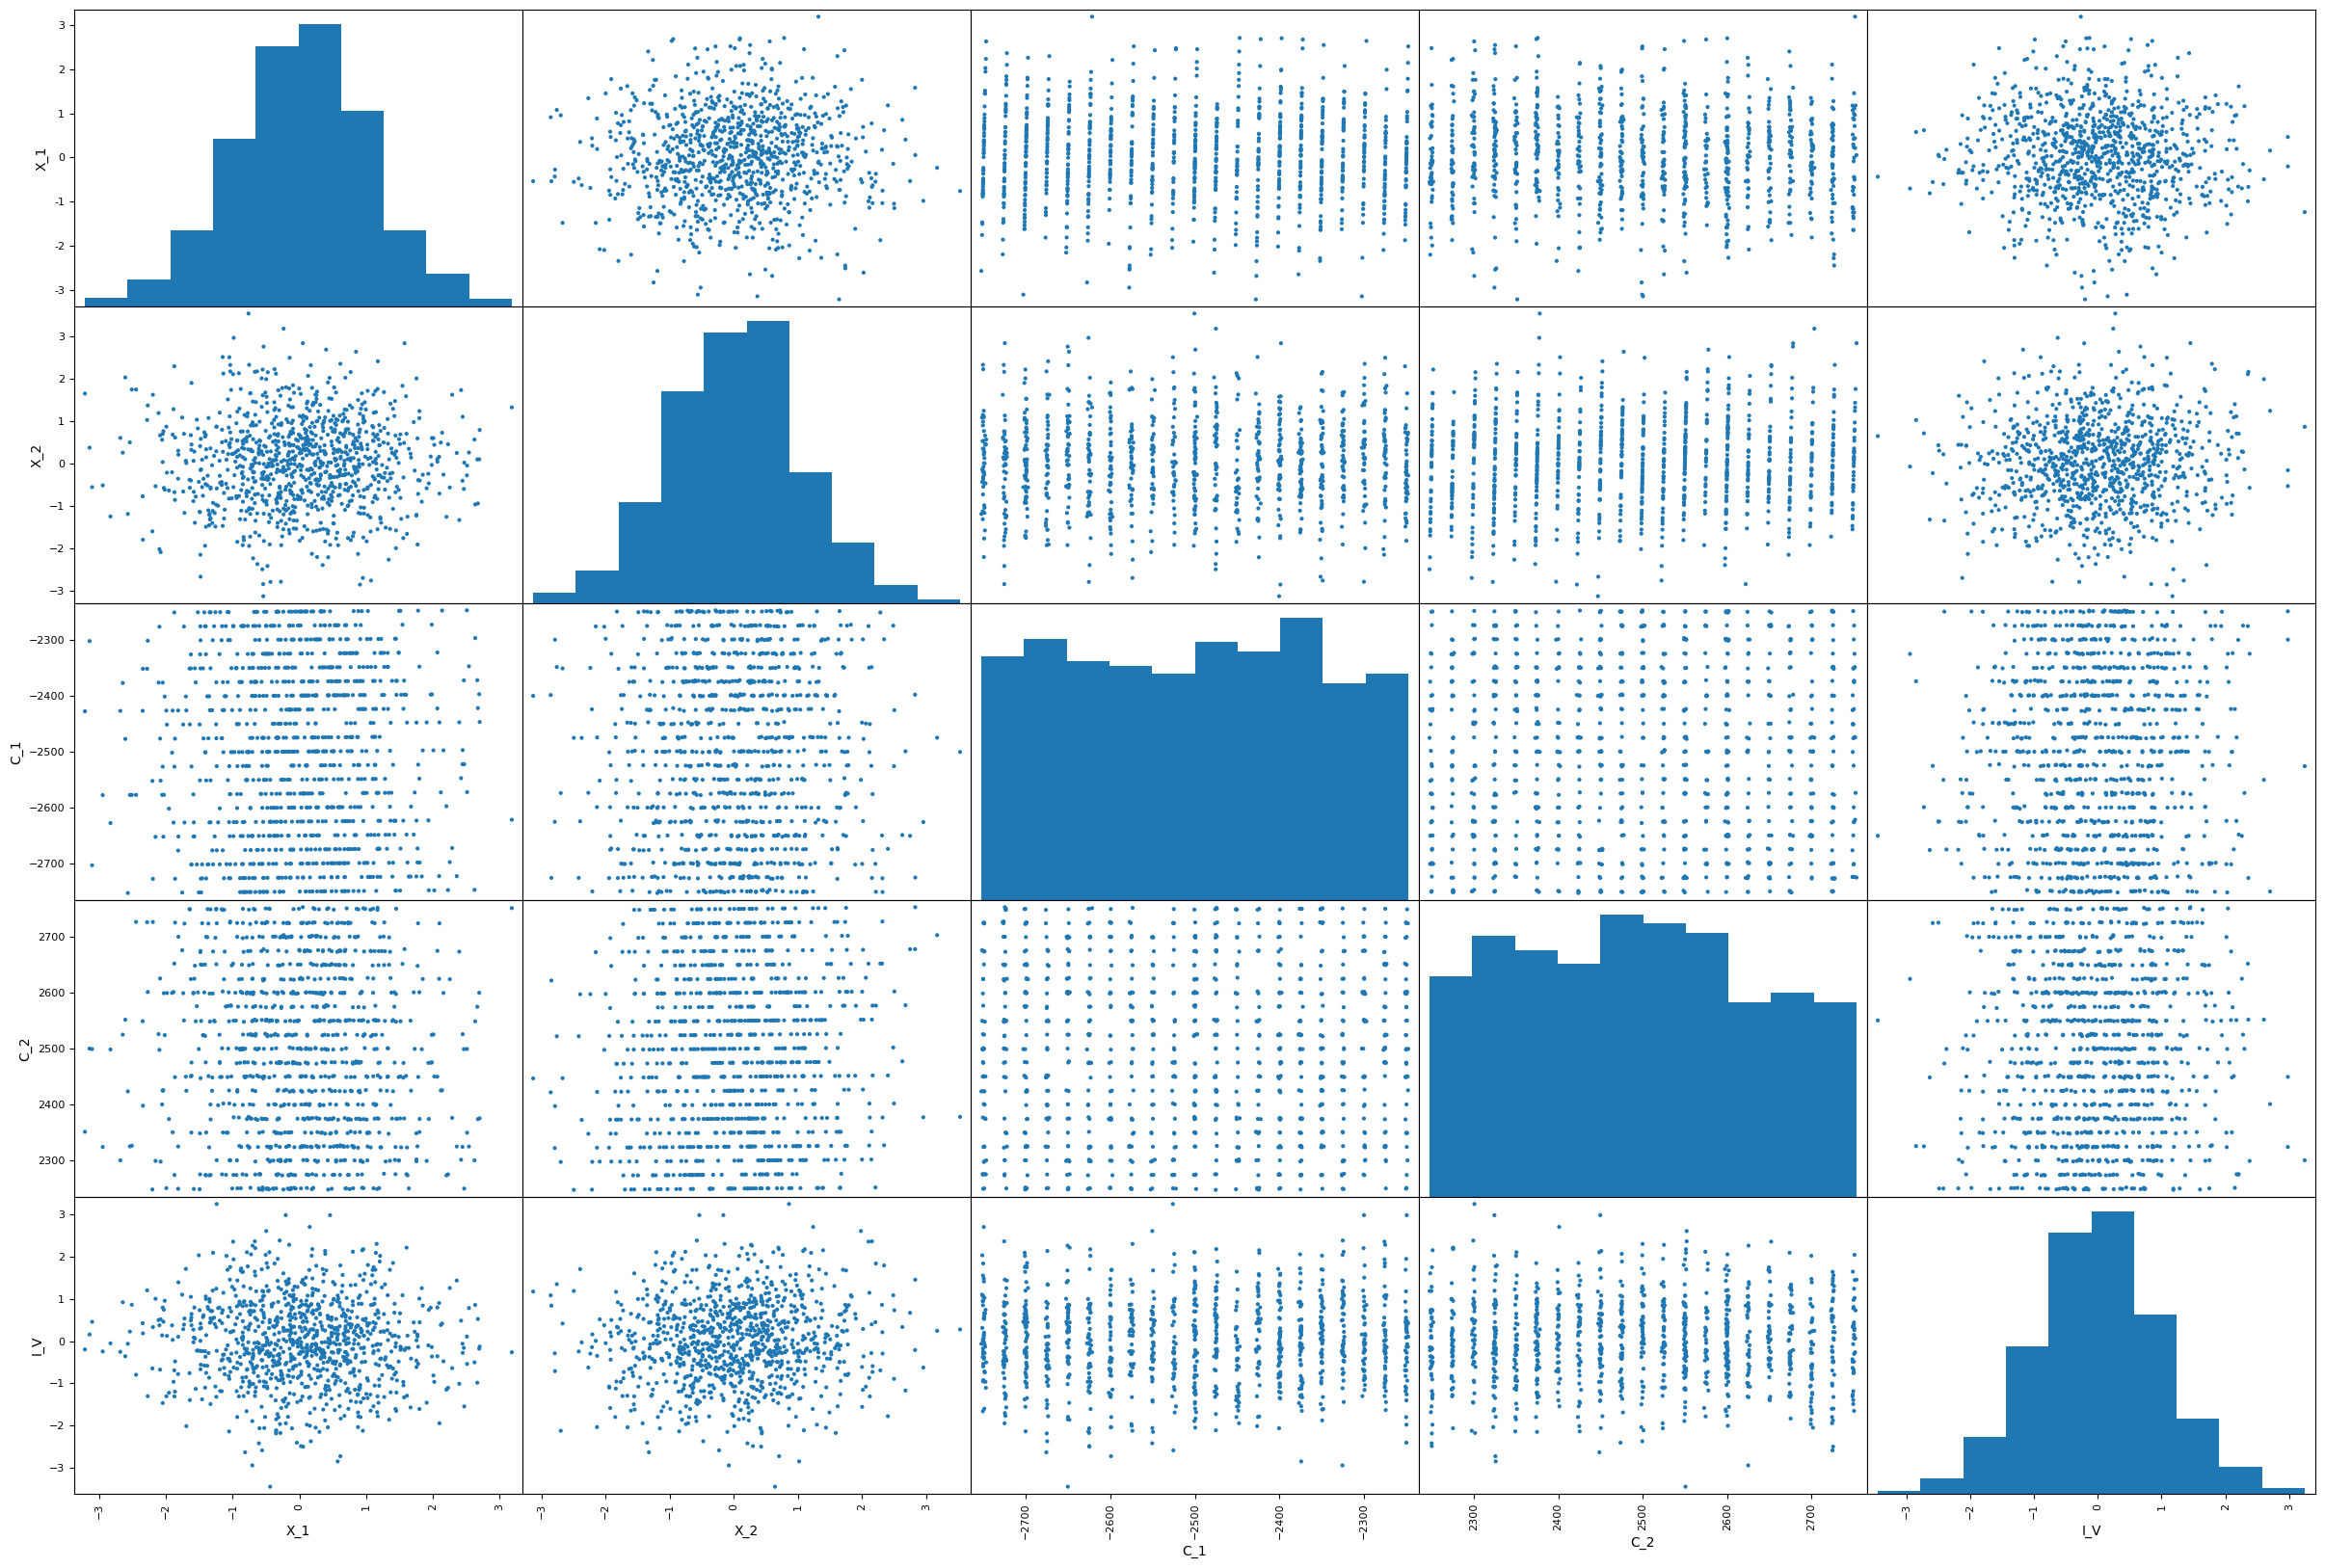

In [4]:
plt.clf()
# define the plot
pd.plotting.scatter_matrix(model_df, alpha = 1, figsize = (30, 20), diagonal = "hist")

# show the plot
plt.show()

#### The Variance Inflation Factor (VIF):

Estimated standard error of $\hat{\beta_j}$ in a multiple regression:

$ s_{\hat{\beta_j}} = s_\epsilon \sqrt{\frac{1}{\sum{(x_{ij} - \bar{x_j})^2 (1 - R^2_j)}}}$

 - $\hat{\beta_j}$ = estimated regression parameters
 - j-th partial slope
 - i-th level of the independent variable
 - $\bar{x_j}$ = mean $x_j$
 - $s_\epsilon$ = residual standard deviation for the multiple regression of y on $x_1$, $x_2$, ... $x_k$
 - $R_j^2$ = the coefficient of determination from the regression of $x_j$ on the remaining k - 1 explanatory variables ($R_j^2$ of the model without $x_j$)

The VIF measures how much the variance (square of the standard error) of a coefficient is increased because of collinearity.

$VIF_j = \frac{1}{1-R_j^2}$


In [5]:
# Variance Inflation Factor, before and after dropping independent variables ------------------------------------------------- #

# dataframes of explaining variables (x), having removed the explained variable (y) ------------------------------------------ #
X_1 = all_data_Y_dropped

X_2 = model_df[predicting_variables]

Y = all_data_df[predicted_variable]
  
# VIF dataframe -------------------------------------------------------------------------------------------------------------- #
vif_data_1 = pd.DataFrame()
vif_data_1["feature"] = X_1.columns

vif_data_2 = pd.DataFrame()
vif_data_2["feature"] = X_2.columns
  
# calculating VIF for each feature ------------------------------------------------------------------------------------------- #
vif_data_1["VIF"] = [variance_inflation_factor(X_1.values, i) for i in range(len(X_1.columns))]

vif_data_2["VIF"] = [variance_inflation_factor(X_2.values, i) for i in range(len(X_2.columns))]

print("VIF=1: vars not correlated, 1<VIF<=5: vars moderatly correlated, 5<VIF<=10: vars highly correlated, VIF>10: abandon all hope")
print("")
print("Before dropping explaining variables:")
print(vif_data_1)
print("")
print("After dropping explaining variables:")
print(vif_data_2)

VIF=1: vars not correlated, 1<VIF<=5: vars moderatly correlated, 5<VIF<=10: vars highly correlated, VIF>10: abandon all hope

Before dropping explaining variables:
  feature         VIF
0     X_1    1.007615
1     X_2    1.007704
2     D_1    1.006536
3     D_2    1.001769
4     C_1  141.461733
5     C_2  141.436004
6     I_V    1.009281

After dropping explaining variables:
  feature         VIF
0     X_1    1.006013
1     X_2    1.006180
2     C_1  141.325869
3     C_2  141.318244
4     I_V    1.006492


#### Checking for Outliers

The following descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, I included the marks for 3 times the standard deviation, to make it easy to spot if there are any outliers.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

In [6]:
# get describtion of datadistribution ---------------------------------------------------------------------------------------- #
descr_df = model_df.describe()

# add 3-times standard deviation metric -------------------------------------------------------------------------------------- #
descr_df.loc["+ 3 * std"] = descr_df.loc["mean"] + (descr_df.loc["std"] * 3)
descr_df.loc["- 3 * std"] = descr_df.loc["mean"] - (descr_df.loc["std"] * 3)

descr_df

,X_1,X_2,C_1,C_2,I_V
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.032629,0.023949,-2502.938168,2493.577326,-0.000289
std,1.016520,1.022481,152.510041,146.965866,0.986937
min,-3.216528,-3.128174,-2752.644779,2247.732613,-3.445651
25%,-0.636615,-0.649018,-2648.283379,2373.670599,-0.623538
50%,0.043675,0.041318,-2500.109028,2499.261787,-0.028900
75%,0.701193,0.675098,-2374.472402,2601.559656,0.652670
max,3.187863,3.529977,-2247.824185,2753.178214,3.242007
+ 3 * std,3.082190,3.091394,-2045.408044,2934.474923,2.960522
- 3 * std,-3.016931,-3.043495,-2960.468292,2052.679728,-2.961099


In [7]:
# splitting the dataframe into dependent and independent variables ----------------------------------------------------------- #

X = X_2
Y = Y

# split the data into train and test groups ---------------------------------------------------------------------------------- #
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)
print(y_test)
# create linear_regression_model_object -------------------------------------------------------------------------------------- #
regression_model = LinearRegression()

# fit the model to the data -------------------------------------------------------------------------------------------------- #
regression_model.fit(X_train, y_train)

            Y
507 -1.435604
818  0.442938
452  0.645078
368 -0.465854
242 -0.458008
..        ...
430 -0.698313
874 -0.039304
550 -0.566469
608  0.280574
207 -0.274999

[200 rows x 1 columns]


LinearRegression()

In [8]:
# intercept and coefficients of the model ------------------------------------------------------------------------------------ #

intercept = regression_model.intercept_[0]
coefficent = regression_model.coef_[0][0]

print("# Intercept " + "-"*113 + " #")

print("The intercept for the model is {:.4}".format(intercept))
print("")
print("# Coefficients " + "-"*110 + " #")

for coef in zip(X.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.4}".format(coef[0],coef[1]))

print("")
print("# R² of the model " + "-"*107 + " #")
print(regression_model.score(X, Y))

# Intercept ----------------------------------------------------------------------------------------------------------------- #
The intercept for the model is -0.005124

# Coefficients -------------------------------------------------------------------------------------------------------------- #
The Coefficient for X_1 is 0.3984
The Coefficient for X_2 is 0.3954
The Coefficient for C_1 is 1.897e-05
The Coefficient for C_2 is 2.1e-05
The Coefficient for I_V is 0.1994

# R² of the model ----------------------------------------------------------------------------------------------------------- #
0.9933149288845654


In [9]:
# add constant (1.0) to X ---------------------------------------------------------------------------------------------------- #
Xc = sm.add_constant(X_train)

# creating the model object -------------------------------------------------------------------------------------------------- #
model = sm.OLS(y_train, Xc)

# fitting the data to the model (assigned in prev. step, est = RegressionResults) -------------------------------------------- #
est = model.fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 2.364e+04
Date:                Sun, 19 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:07:51   Log-Likelihood:                 1256.1
No. Observations:                 800   AIC:                            -2500.
Df Residuals:                     794   BIC:                            -2472.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.042     -0.123      0.9

In [10]:
# "manual" calculation of coefficient matrix, as proof of method ------------------------------------------------------------- #

# beta_estimator = (X^T X)^{-1} X^T y

y_estimator = np.array(all_data_df[predicted_variable[0]])
X_const_estimator = np.array([[1] for x in range(1000)])
X_var_estimator = np.array(all_data_df[predicting_variables])
X_estimator = np.concatenate((X_const_estimator, X_var_estimator), axis=1)
X_T_estimator = np.transpose(X_estimator)
# matrix multiplikation operator in numpy: @

#beta_estimator = np.linalg.inv(X_T_estimator @ X_estimator) @ X_T_estimator @ y_estimator
beta_estimator = np.linalg.pinv(X_estimator) @ y_estimator

beta_estimator_4dec = np.around(beta_estimator,decimals=4)

print("# Coefficients calculated using matrix operations" + "-"*(122 - len("Coefficients calculated using matrix operations")) + " #")
print("Intercept: " + str(beta_estimator_4dec[0]))
print("beta_0: " + str(beta_estimator_4dec[1]))

for i in range(len(beta_estimator_4dec)):
    if i <= 1:
        pass
    else:
        print("beta_" +str(i-1)+ ": " + str(beta_estimator_4dec[i]))


# Coefficients calculated using matrix operations--------------------------------------------------------------------------- #
Intercept: -0.0357
beta_0: 0.3985
beta_1: 0.3964
beta_2: 0.0
beta_3: 0.0
beta_4: 0.199


### Checking the Model Assumptions

The assumptions for multiple regression are defined in terms of the random errors $\epsilon_i$, which means, they can be verified by using the residuals $e_i = y_i - \hat{y}_i$, which are estimates of $\epsilon_i$.

#### Scatterplot with fitted Line Plot:

Gives you a rough idea of the relationship between $x_k$ and y, if you need to transform $x_k$ and also allows to make conclusions in regards to correlation. (Technically same as Matrix of Scatterplots, but in regards to $x_i$ relationship to y.)
A lowess (locally weighted linear regression) can be used instead of a linear regression fit line, which in some cases is better suited to identify the $x_i$, y relationship.

https://seaborn.pydata.org/generated/seaborn.regplot.html

<Figure size 640x480 with 0 Axes>

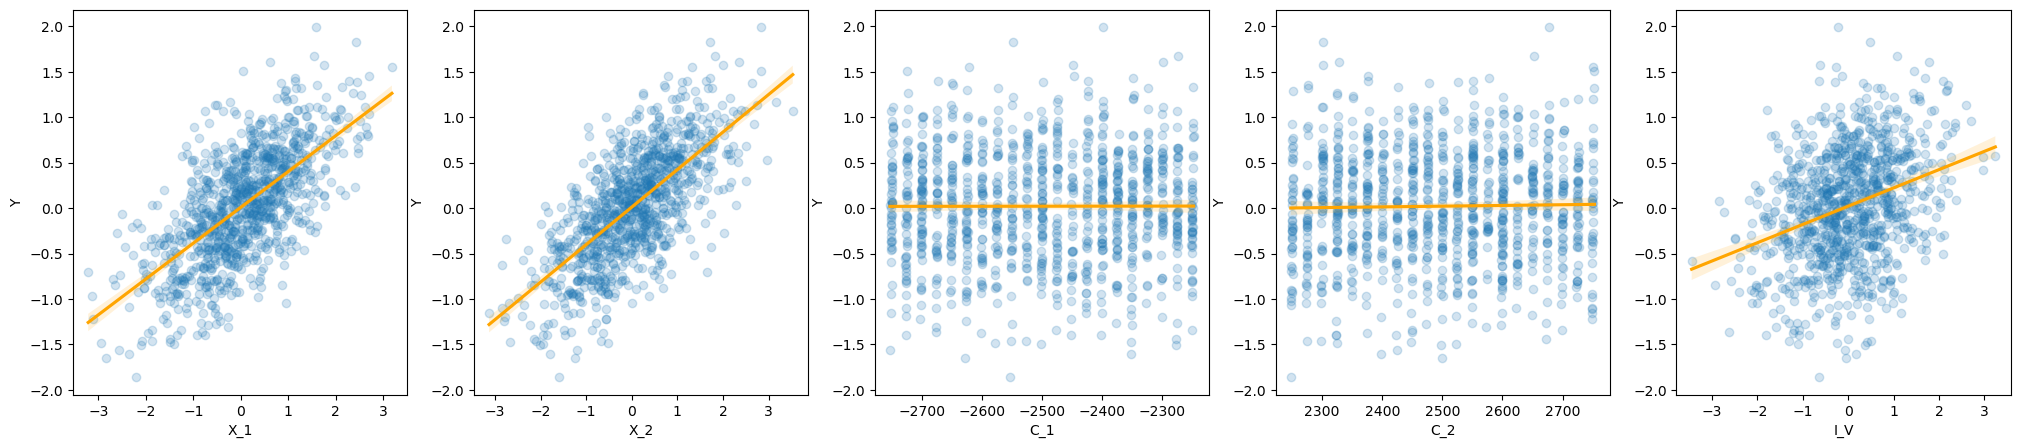

In [11]:
# plotting the data in a scatterplot with a fitted line plot ----------------------------------------------------------------- #
plt.clf()

n_X = len(model_df.columns)

fig = plt.figure(figsize=(5 * n_X ,5))

for i in range(1, n_X+1):
    ax = fig.add_subplot(1, n_X, i)
    sns.regplot(x=model_df[predicting_variables[i-1]], y=Y, line_kws={"color":"orange"}, scatter_kws={"alpha":0.2})

plt.show()

#### Checking the zero expectation of the Residuals

When the residuals roughly have a mean of 0 and a constant variance, with $Var(e_i) = \sigma_e^2 (1 - h_{ii})$, where $h_{ii}$ are the diagonal elements  of the hat matrix $H = {X(X'X)}^{-1} X'$ .

In [12]:
mean_resid, std_resid = stats.norm.fit(est.resid)

hat_matrix = X_estimator @ np.linalg.inv(np.transpose(X_estimator) @ X_estimator) @ np.transpose(X_estimator)

h_ii_lst = list()
for i in range(len(hat_matrix)):
    h_ii_lst.append(hat_matrix[i,i])

student_resid_lst = list()
for i in range(len(list(est.resid))):
    st_resid = (list(est.resid)[i]/std_resid) * np.sqrt(1 - h_ii_lst[i])
    student_resid_lst.append(st_resid)

    
print("")
print("Mean of the residuals:")
print(mean_resid)
print("")
print("Standard Deviation:")
print(std_resid)
print("")
print("Mean_Studentized_Residuals:")
print(np.mean(student_resid_lst))
print("")
print("Variance_Studentized_Residuals:")
print(np.var(student_resid_lst))


Mean of the residuals:
-1.8782267408035124e-13

Standard Deviation:
0.050331497156696034

Mean_Studentized_Residuals:
-2.5862470429409702e-05

Variance_Studentized_Residuals:
0.994414251164156


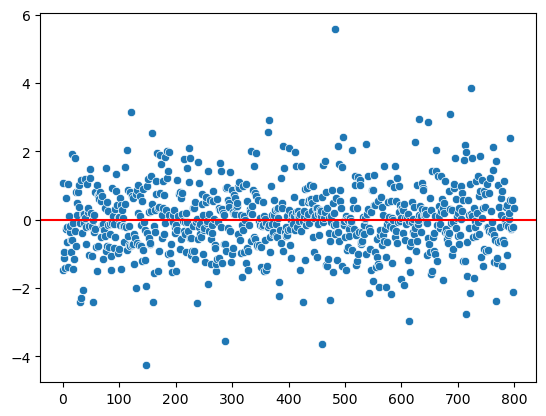

In [13]:
stud_res_plot = sns.scatterplot(student_resid_lst)
stud_res_plot.axhline(0, color = "red")

#### Distribution of Residuals:

Distribution of residuals is most commanly visualized in two different ways, not being a substitute for hypothesis testing, allows for quick identification of what might be the issue, in case the residuals are not normally distributed.

They also can be more reliable from a practical point of view, when dealing with large sample sizes:
"However, they have their limitations because with large sample sizes it is very easy to get significant 
results from small deviations from normality, and so a significant test doesn’t necessarily tell us 
whether the deviation from normality is enough to bias any statistical procedures that we apply 
to the data." - Discovering Statistics using SPSS, p144, Andy Field, 2009, Third Edition
(There is different tests for the normal distribution of the residuals, they are more sensitive to different types of systemic deviation from normality, a visualization of the distribution of the residuals can allow a quick identification, which test is best suited for the given residuals)

https://seaborn.pydata.org/generated/seaborn.histplot.html

https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.ProbPlot.html

<Figure size 640x480 with 0 Axes>

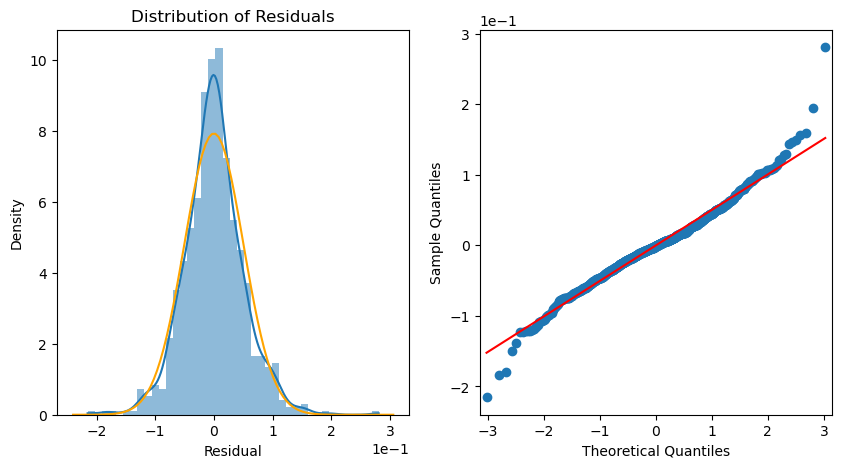

In [14]:
# Visualization of Error Normality ------------------------------------------------------------------------------------------- #
plt.clf()
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
# left visualization --------------------------------------------------------------------------------------------------------- #
sns.histplot(x = est.resid, ax=ax, stat = "density", linewidth = 0, kde = True)
ax.set(title="Distribution of Residuals", xlabel="Residual")

# normalcurve, for easy comparrison ------------------------------------------------------------------------------------------ #
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean_resid, std_resid)
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

#  right visualization ------------------------------------------------------------------------------------------------------- #
ax = fig.add_subplot(1,2,2)
sm.ProbPlot(est.resid).qqplot(line='s', ax=ax)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


plt.show()

#### Tests for Error Normality

##### Shapiro-Wilk-Test:

The Shapiro-Wilk test calculates "W" that tests wether a random sample $x_1, x_2, ..., x_n$ comes specifically from a normal distribution. The test statistic is obtained by dividing the square of an appropriate linear combination of the sample order statistics by the usual symmetric estimate of variance, optained via Monte Carlo Simulations.
"W test is comparatively quite sensitive to a wide range of non-normality, even with samples as small as n = 20. It seems to be especially sensitive to asymmetry, long-tailedness and to some degree to short-tailedness." - [2]

$W = \frac{(\displaystyle\sum_{i=1}^n a_i x_{(i)})^2}{\displaystyle\sum_{i=1}^n (x_i - \bar{x})^2}$

 - $x_{(i)}$ i-th smalles number in the sample
 - $\bar{x}$ = mean x
 - $a_i$ = constant generated from the means, variances, and covariances of the order statistics of a sample of size n from a normal distribution
 
https://www.cambridge.org/core/journals/journal-of-the-institute-of-actuaries/article/abs/biometrika-tables-for-statisticians-volume-ii-edited-by-e-s-pearson-and-h-o-hartley-pp-xviii-385-published-for-the-biometrika-trustees-at-the-cambridge-university-press-1972-500/817D1F97132514B805526B9793C3B37A [1] (5 BP, or access from a university library)

http://www.bios.unc.edu/~mhudgens/bios/662/2008fall/Backup/wilkshapiro1965.pdf [2]

##### Anderson-Darling-Test:

Modified Kolmogorov-Smirnov test, that gives more weight to the tails, than the original, in addition it makes use of the specific distribution in calculation of it's critical values. It's more sensitive than the Kolmogorov-Smirnov test. Test is one-sided, rejection if A > critical value.

$A^2 = -n - S$

$S = \displaystyle\sum_{i=1}^n \frac{2i-1}{n} [ln F(Y_i) + ln (1 - F(Y_{n+1-i}))]$

 - F = cumulative distribution function
 - Y_i = ordered data
 - n = number of observations

https://www.math.utah.edu/~morris/Courses/6010/p1/writeup/ks.pdf

##### Kolmogorov-Smirnov-Test:

The Kolmogorov-Smirnov test is based on the empirical distribution function (ECDF). More sensitive near the center of the distribution than its tails. Given N ordered data points $Y_1, Y_2, ..., Y_N$, the ECDF is defined as:

$E_N = \frac{n(i)}{N}$

$D = \max\limits_{1<=i<=N} (F(Y_i) - \frac{i-1}{N}, \frac{i}{N} - F(Y_i))$

 - N = number of ordered data points $Y_i$
 - F = continuous, fully specified thoretical cumulative distribution of the distribution being tested
 - n(i) = number of points less than $Y_i$


In [15]:
# Tests for Error Normality -------------------------------------------------------------------------------------------------- #

# Shapiro-Wilk-Test for Normality -------------------------------------------------------------------------------------------- #
sw_stat, sw_p = stats.shapiro(est.resid)
print("# Shapiro-Wilk-Test for Normality " + "-"*(122 - len("Shapiro-Wilk-Test for Normality")) + " #")
print("Test Statistic:")
print(sw_stat)
print("P-Value:")
print(sw_p)
print("")

print("Null Hypothesis:")
print("The data was drawn from a normal distribution.")
print("Alternative Hypothesis:")
print("The data was NOT drawn from a normal distribution.")
print("")

if sw_p <= alpha:
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")
print("")

# Anderson-Darling-Test for Normality ---------------------------------------------------------------------------------------- #
def reject_null(stat, cv_arr, sl_arr, alpha):
    sl = 0
    index = 0
    sl_lst = np.ndarray.tolist(sl_arr)
    cv_lst = np.ndarray.tolist(cv_arr)
    for level in sl_lst:
        if level == alpha * 100:
            sl = level
            index = sl_lst.index(level)
    if cv_lst[index] < stat:
        return True
    else:
        return False

ad_stat, ad_cv, ad_sl = stats.anderson(est.resid)
print("# Anderson-Darling-Test for Normality " + "-"*(122 - len("Anderson-Darling-Test for Normality")) + " #")
print("Test Statistic:")
print(ad_stat)
print(f"Critical Value: {ad_cv}")
print(f"Significance Level: {ad_sl}")
print("")

print("Null Hypothesis:")
print("The sample is drawn from a population that follows a particular distribution. (Normal Distribution)")
print("Alternative Hypothesis:")
print("The sample is NOT drawn from a population that follows a particular distribution. (Normal Distribution)")
print("")

if reject_null(ad_stat, ad_cv, ad_sl, alpha):
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")
print("")

# Kolmogorov-Smirnov-Test for Normality -------------------------------------------------------------------------------------- #
ks_stat, ks_p = stats.kstest(est.resid, stats.norm.cdf)
print("# Kolmogorov-Smirnov-Test for Normality " + "-"*(122 - len("Kolmogorov-Smirnov-Test for Normality")) + " #")
print("Test Statistic:")
print(ks_stat)
print("P-Value:")
print(ks_p)
print("")

print("Null Hypothesis:")
print("The two distributions are identical, F(x)=G(x) for all x. (default: two-sided)")
print("Alternative Hypothesis:")
print("They are NOT identical.")
print("")

if ks_p <= alpha:
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")


# Shapiro-Wilk-Test for Normality ------------------------------------------------------------------------------------------- #
Test Statistic:
0.980243444442749
P-Value:
6.3102389979974305e-09

Null Hypothesis:
The data was drawn from a normal distribution.
Alternative Hypothesis:
The data was NOT drawn from a normal distribution.

Reject the null hypothesis, in favor of the alternative hypothesis.

# Anderson-Darling-Test for Normality --------------------------------------------------------------------------------------- #
Test Statistic:
3.2648851689323237
Critical Value: [0.573 0.653 0.783 0.913 1.087]
Significance Level: [15.  10.   5.   2.5  1. ]

Null Hypothesis:
The sample is drawn from a population that follows a particular distribution. (Normal Distribution)
Alternative Hypothesis:
The sample is NOT drawn from a population that follows a particular distribution. (Normal Distribution)

Reject the null hypothesis, in favor of the alternative hypothesis.

# Kolmogorov-Smirnov-T

#### Tests for Constant Error Variance

##### Levene Test for Equal Variances:

Tests if k samples have equal variances. The Levene test is less sensitive than the Bartlett test to departures from normality. Using the mean of Y, is best suited for symmetric, moderate-tailed, distributions, the trimmed mean, performs best for heavy-tailed distributions, the median performs best for skewed distributions.

$W = \frac{(N - k)}{(k - 1)} \frac{\displaystyle\sum_{i=1}^k N_i (Z_i. - Z..)^2}{\displaystyle\sum_{i=1}^k \displaystyle\sum_{j=1}^{N_i} (Z_{ij} - Z_i.)^2}$

$Z_{ij} = |Y_{ij} - \tilde{Y}_{ij}|$

 - W = Test-Statistic
 - k is the number of different groups to which the sampled cases belong,
 - $N_{i}$ is the number of cases in the ith group,
 - N is the total number of cases in all groups,
 - $Y_{ij}$ is the value of the measured variable for the
 - jth case from the ith group
 - $\tilde{Y_i}$ = median of the i-th group (default, can also be mean or trimmed = cut % from each end of values)


##### Bartlett's Test for Equal Variances:

Tests if k samples have equal variances. Bartlett's test is sensitive to departures from normality, if you have strong evidence that your data do in fact come from a normal, or nearly normal, distribution, then Bartlett's test has better performance than Levene's Test.

$T = \frac{(N - k) ln (s_p^2) - \displaystyle\sum_{i=1}^k (N_i - 1) ln (s_i^2)}
{1 + \frac{1}{3(k - 1)} ( \displaystyle\sum_{i=1}^k (\frac{1}{N_i - 1}) - \frac{1}{N - k})}$

$s_p^2 = \frac{1}{N - k} \displaystyle\sum_{i} (n_i - 1) s_i^2$

 - $s_i^2$ = variance of the ith group
 - N = total sample size
 - $N_i$ = sample size of the ith group
 - k = number of groups
 - $s_p^2$ = pooled variance

The variances are judged unequal if:

$T > \chi_{1-\alpha, k-1}^2$

is the critical value of the chi-square distribution with k - 1 degrees of freedom and a significance level of $\alpha$.


##### Breusch-Pagan Test for Constant Error Variance:

The Breusch-Pagan Test tests whether the variance of the errors from a regression is dependent on the values of the independent variables, which when present would proof heteroscedasticity.

$BP = \frac{SS(Regression) / 2}{(SS(Residuals) /n)^2}$

 - $e_i = y_i - \hat{y}_i$ = unstandardized residuals
 - SS(Residuals) = Sum Squared Residuals
 - SS(Regression) = the regression sum of squares from fitting the model with $e_i^2$ as the response variable


In [16]:
# Tests for Constant Error Variance ------------------------------------------------------------------------------------------ #

# Levene Test for Equal Variances -------------------------------------------------------------------------------------------- #
sample_1 = est.resid[:79]
sample_2 = est.resid[80:]

l_stat, l_p = stats.levene(sample_1, sample_2, center="median")
print("# Levene Test for Equal Variances, significant deviations from normality" + "-"*(122 - len("Levene Test for Equal Variances, significant deviations from normality")) + " #")
print("Test Statistic:")
print(l_stat)
print("P-Value:")
print(l_p)
print("")

print("Null Hypothesis:")
print("All input samples are from populations with equal variances. (More robust with significantly non-normal populations)")
print("Alternative Hypothesis:")
print("NOT all input samples are from populations with equal variances.")
print("")

if l_p <= alpha:
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")
print("")

# Bartlett's Test for Equal Variances ---------------------------------------------------------------------------------------- #
b_stat, b_p = stats.bartlett(sample_1, sample_2)
print("# Bartlett'S Test for Equal Variances, NO significant deviations from normality" + "-"*(122 - len("Bartlett'S Test for Equal Variances, NO significant deviations from normality")) + " #")
print("Test Statistic:")
print(b_stat)
print("P-Value:")
print(b_p)
print("")

print("Null Hypothesis:")
print("All input samples are from populations with equal variances.")
print("Alternative Hypothesis:")
print("NOT all input samples are from populations with equal variances.")
print("")

if b_p <= alpha:
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")
print("")

# Breusch-Pagan Test for Constant Error Variance ----------------------------------------------------------------------------- #
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(est.resid, est.model.exog)
print("# Breusch-Pagan Test for Constant Error Variance " + "-"*(122 - len("Breusch-Pagan Test for Constant Error Variance")) + " #")
print("Test Statistic (LM, F):")
print(f"{lm}, {fvalue}")
print("P-Value (LM, F):")
print(f"{lm_pvalue}, {f_pvalue}")
print("")

print("Null Hypothesis:")
print("The variance is constant.")
print("Alternative Hypothesis:")
print("The variance is NOT constant.")
print("")

if f_pvalue <= alpha:
    print("Reject the null hypothesis, in favor of the alternative hypothesis.")
else:
    print("Do not reject the null hypothesis.")


# Levene Test for Equal Variances, significant deviations from normality---------------------------------------------------- #
Test Statistic:
0.06160538406158438
P-Value:
0.8040402606561168

Null Hypothesis:
All input samples are from populations with equal variances. (More robust with significantly non-normal populations)
Alternative Hypothesis:
NOT all input samples are from populations with equal variances.

Do not reject the null hypothesis.

# Bartlett'S Test for Equal Variances, NO significant deviations from normality--------------------------------------------- #
Test Statistic:
0.22983256093874635
P-Value:
0.6316480098204537

Null Hypothesis:
All input samples are from populations with equal variances.
Alternative Hypothesis:
NOT all input samples are from populations with equal variances.

Do not reject the null hypothesis.

# Breusch-Pagan Test for Constant Error Variance ---------------------------------------------------------------------------- #
Test Statistic (LM, F):


C:\Users\Maximilian\AppData\Local\Temp\ipykernel_17028\1384633247.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sample_1 = est.resid[:79]
C:\Users\Maximilian\AppData\Local\Temp\ipykernel_17028\1384633247.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sample_2 = est.resid[80:]


#### Durbin Watson Test for first Order Autocorrelation

The DW-Statistic ranges from 0 to 4, with 2 meaning that the $H_0$ of no autocorrelation is correct and values smaller 2, that there is positive and values larger 2 meaning that there is negative autocorrelation.

$\hat{\epsilon_i} = y_i - \hat{y_i}$

$DW = \frac{\displaystyle\sum_{t=2}^n (\hat{\epsilon}_t - \hat{\epsilon}_{t-1})^2}{\displaystyle\sum_{t=1}^n \hat{\epsilon}_t^2}$

 - $\epsilon_t$ = Residuals of the t-th period


# Durbin Watson Test for 1. Order Autocorrelation--------------------------------------------------------------------------- #
(Test Statistic should be roughly identical with Durbin-Watson Value in est.summary() printout.)
Test Statistic:
1.9798815522760465
Null Hypothesis:
There is no 1. Order Autocorrelation
Alternative Hypothesis:
There is 1. Order Autocorrelation

Do not reject the null hypothesis.


<Figure size 640x480 with 0 Axes>

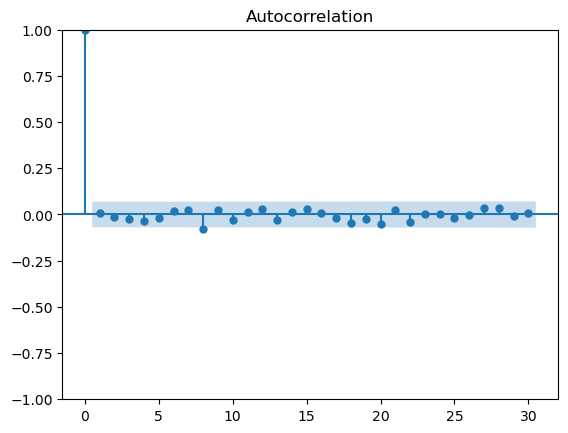

In [17]:
# Tests for Autocorrelation -------------------------------------------------------------------------------------------------- #
# Durbin Watson Test for first Order Autocorrelation ------------------------------------------------------------------------- #
dw_stat = durbin_watson(est.resid, axis=0)

print("# Durbin Watson Test for 1. Order Autocorrelation" + "-"*(122 - len("Durbin Watson Test for 1. order Autocorrelation")) + " #")
print("(Test Statistic should be roughly identical with Durbin-Watson Value in est.summary() printout.)")
print("Test Statistic:")
print(dw_stat)

print("Null Hypothesis:")
print("There is no 1. Order Autocorrelation")
print("Alternative Hypothesis:")
print("There is 1. Order Autocorrelation")
print("")

if 0 <= dw_stat < 1.5:
    print("Reject the null hypothesis, in favor of the alternative hypothesis. There is positive autocorrelation")
elif 2.5 < dw_stat <= 4:
    print("Reject the null hypothesis, in favor of the alternative hypothesis. There is negative autocorrelation")
elif 1.5 <= dw_stat <= 2.5:
    print("Do not reject the null hypothesis.")
else:
    print("Something ain't right.")

# plot of autocorrelation within the residuals ------------------------------------------------------------------------------- #
plt.clf()
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

#### Confidence Intervals

The confidence interval for $\beta_j$ is:

($\hat\beta_j$ - $t_\frac{\alpha}{2}$ $s_{\hat\beta_j}$, $\hat\beta_j$ + $t_\frac{\alpha}{2}$ $s_{\hat\beta_j}$)

where $t_\frac{\alpha}{2}$ cuts of area $\frac{\alpha}{2}$ in the tail of a t distribution with df = n - (k + 1), the error df.

With $s_\epsilon$ being the standard deviation from the regression equation and $v_jj$ is the entry in row j + 1, column j + 1 of $(X'X)^{-1}$, with X already being known, this can be solved with matrix operations.

In [18]:
# using the (statsmodels) RegressionResults method conf_int() ---------------------------------------------------------------- #
est.conf_int(alpha = alpha)

,0,1
const,-0.086925,0.076676
X_1,0.394962,0.401831
X_2,0.391952,0.398782
C_1,-0.000004,0.000042
C_2,-0.000003,0.000045
I_V,0.195764,0.202938


In [19]:
# calculating the confidence intervall manually using numpy matrix operations ------------------------------------------------ #
# our least-squares estimator ------------------------------------------------------------------------------------------------ #
beta_estimator_4dec
# the alpha for our confidence intervall ------------------------------------------------------------------------------------- #
alpha
# the standard error of our least-squares estimator -------------------------------------------------------------------------- #
s_e = np.sqrt(est.mse_resid)

# appending intercept, estimator vifs
vif_lst = list()
for i in range(len(Xc.columns)):
    vif = variance_inflation_factor(exog = Xc.values, exog_idx = i)
    vif_lst.append(vif)
    
# degrees of freedom --------------------------------------------------------------------------------------------------------- #
n = est.nobs
k = len(X_train.columns)
df = n - (k + 1)

# \bar X , mean_X_j ---------------------------------------------------------------------------------------------------------- #
X_means = np.mean(X_estimator, axis=0)

# sum squared of x_residuals ------------------------------------------------------------------------------------------------- #
x_diffs_sq = np.empty_like(X_estimator)
for i in range(len(X_estimator)):
    x_diffs_sq[i, :] = (X_estimator[i, :] - X_means)**2

S_xx = np.sum(x_diffs_sq, axis=0)

# standard error for each \hat\beta ------------------------------------------------------------------------------------------ #
'''
std_error_estimator_lst = list()
for i in range(len(beta_estimator_4dec)):
    std = s_e * np.sqrt((1 / S_xx[i]) * vif_lst[i])
    std_error_estimator_lst.append(std)
    print(std)
'''

V = np.linalg.inv(np.transpose(X_estimator) @ X_estimator)

std_error_estimator_lst = list()
for j in range(len(beta_estimator_4dec)):
    v_jj = V[j][j]
    std = s_e * np.sqrt(v_jj)
    std_error_estimator_lst.append(std)
    
# t-value from table based on alpha and df ----------------------------------------------------------------------------------- #
t_value = special.stdtrit(df, 1 - alpha)

# confidence intervals table ------------------------------------------------------------------------------------------------- #
upper_ci_lst = list()
lower_ci_lst = list()

for j in range(len(beta_estimator_4dec)):
    intervall = t_value * std_error_estimator_lst[j]
    upper = round(beta_estimator_4dec[j] + intervall, 4)
    lower = round(beta_estimator_4dec[j] - intervall, 4)
    upper_ci_lst.append(upper)
    lower_ci_lst.append(lower)

index_lst = list()
for i in range(len(beta_estimator_4dec)):
    if i < 1:
        index_lst.append("const")
    else:
        index_lst.append("X_" +str(i-1))
    
ci_df = pd.DataFrame(data=[lower_ci_lst, upper_ci_lst], index=["0", "1"], columns=index_lst).transpose()
ci_df

,0,1
const,-0.0978,0.0264
X_0,0.3959,0.4011
X_1,0.3938,0.3990
X_2,-0.0000,0.0000
X_3,-0.0000,0.0000
X_4,0.1963,0.2017


#### Prediction using the Model

To look at the viability of the model, a comparison of predictions by the model, to the actual observations of the model is a good start. A visual representation gives a good idea, if there is anything glaringly wrong with the predictions, which might give a hint on where to start looking.

C:\Users\Maximilian\AppData\Local\Temp\ipykernel_17028\2812757985.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_vs_pred_df["index"] = Y_vs_pred_df.index


<Figure size 640x480 with 0 Axes>

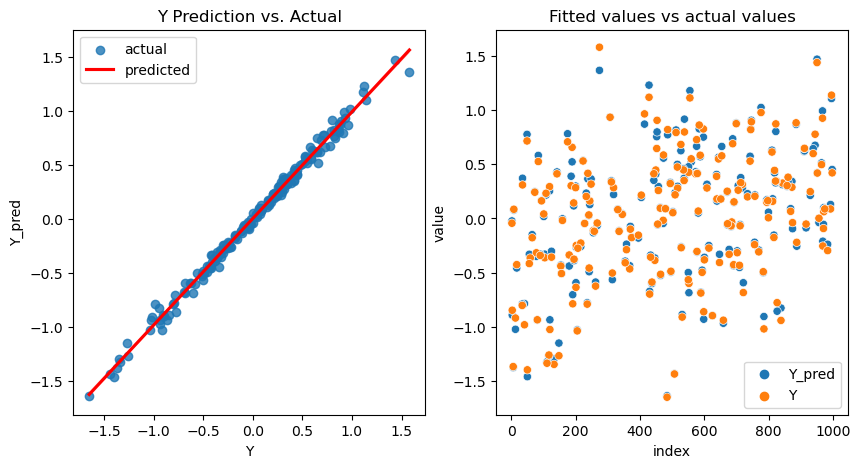

In [20]:
# comparison of y_predict to the actual y_test ------------------------------------------------------------------------------- #
y_predict = regression_model.predict(X_test)
test_df = y_test.join(X_test)
test_df.insert(loc=1, column="Y_pred", value=y_predict)

Y_vs_pred_df = test_df[["Y_pred", "Y"]]

# visualisation of y_predict to the actual y_test ---------------------------------------------------------------------------- #
plt.clf()
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)

sns.regplot(Y_vs_pred_df, x="Y", y="Y_pred", ax=ax, line_kws={"color":"red"})
ax.set(title = "Y Prediction vs. Actual")
plt.legend(["actual", "predicted"])


Y_vs_pred_df["index"] = Y_vs_pred_df.index
out_df = pd.melt(Y_vs_pred_df, id_vars=["index"])
out_df.set_index(out_df["index"])

ax = fig.add_subplot(1,2,2)
sns.scatterplot(out_df, x="index", y="value", hue="variable", ax=ax)
plt.title("Fitted values vs actual values")
plt.legend()

In [21]:
assumptions_met = False
zero_expectation = False
constant_variance = False
normal_assumption = False
independence = False

# zero expectation ----------------------------------------------------------------------------------------------------------- #
if round(np.mean(student_resid_lst), 0) == 0:
    zero_expectation = True
# constant variance ---------------------------------------------------------------------------------------------------------- #
if l_p <= alpha and b_p <= alpha and f_pvalue <= alpha:
    constant_variance = True
# normality ------------------------------------------------------------------------------------------------------------------ #
if sw_p <= alpha and ks_p <= alpha and reject_null(ad_stat, ad_cv, ad_sl, alpha):
    normal_assumption = True
# independence --------------------------------------------------------------------------------------------------------------- #
if 1.5 <= dw_stat <= 2.5:
    independence = True
# regression assumptions ----------------------------------------------------------------------------------------------------- #
if zero_expectation and constant_variance and normal_assumption and independence:
    assumptions_met = True
    
# F-Statistic ---------------------------------------------------------------------------------------------------------------- #
f_outcome = None
if est.f_pvalue >= alpha:
    f_outcome = "The reduced model is favourable to the specified model. Different formulation of the model recommended. Also check selected variables."
else:
    f_outcome = "The F-Statistic, does not indicate, that a reduced model is favourable to the chosen model."


# Brief Summary of the Model ------------------------------------------------------------------------------------------------- #
print("# Explainatory Value of the Model" + "-"*(122 - len("Explainatory Value of the Model")) + " #")
print("The model accounts for " + str(round(est.rsquared, 3)*100) + "% of the variation in " + str(predicted_variable[0]) + ".")
print("")
print("# Model Assumptions" + "-"*(122 - len("Model Assumptions")) + " #")
if assumptions_met:
    print("The model assumptions are not violated:")
else:
    print("Some or all of the model assumptions are violated:")
print("")
if zero_expectation:
    print("The zero expectation of the variance is not violated.")
else:
    print("The zero expectation might be violated, check the number of selected variables and the formulated model.")
if constant_variance:
    print("The model has constant variance.")
else:
    print("The model might not have constant variance. OLS might not be BLUE. ")
if normal_assumption:
    print("The models normal assumption is not violated.")
else:
    print("The models normal assumption might be violated. Check for outliers, only remove if nonsensical. Might be skewed, apply transformation to variable, if suitable.")
if independence:
    print("The indepence of the residuals is not violated.")
else:
    print("There is some autocorrelation present.")
print("")
print("# Independent Variable Selection Criteria" + "-"*(122 - len("Independent Variable Selection Criteria")) + " #")
print("The AIC for the model is " + str(round(est.aic, 1)) + "")
print("The BIC for the model is " + str(round(est.bic, 1)) + "")
print("Solely to be used for comparison to different models from the same data, with the same explained variable.")
print("")
print("# Criteria for Formulating the Model" + "-"*(122 - len("Criteria for Formulating the Model")) + " #")
print("F-statistic: " + str(est.fvalue))
print("Prob (F-statistic): " + str(est.f_pvalue))
print(f_outcome)

# Explainatory Value of the Model------------------------------------------------------------------------------------------- #
The model accounts for 99.3% of the variation in Y.

# Model Assumptions--------------------------------------------------------------------------------------------------------- #
Some or all of the model assumptions are violated:

The zero expectation of the variance is not violated.
The model might not have constant variance. OLS might not be BLUE. 
The models normal assumption is not violated.
The indepence of the residuals is not violated.

# Independent Variable Selection Criteria----------------------------------------------------------------------------------- #
The AIC for the model is -2500.3
The BIC for the model is -2472.2

# Criteria for Formulating the Model---------------------------------------------------------------------------------------- #
F-statistic: 23637.312785095066
Prob (F-statistic): 0.0
The F-Statistic, does not indicate, that a redu

#### Save the model

In [22]:
# save the model to a .sav file ---------------------------------------------------------------------------------------------- #
with open("multiple_linear_regression.sav","wb") as f:
     pickle.dump(regression_model, f)

# load a model from a .sav file ---------------------------------------------------------------------------------------------- #
#with open('my_mulitlinear_regression.sav', 'rb') as pickle_file:
     #regression_model_2 = pickle.load(pickle_file)